In [1]:
import pandas as pd
import pyreadstat
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import resample 
%matplotlib inline
import math
import knn_impute
import seaborn as sns

In [2]:
# https://github.com/Roche/pyreadstat#basic-usage
df, meta = pyreadstat.read_sav("raw/surveydata/EVS_ABM1.sav", encoding='ISO-8859-1')

In [3]:
df.head()

,studyno,studynoc,version,versionc,doi,id_cocas,caseno,intno,year,country,...,v374c,v375,v376,v377,v378,Maintainorder,RelativeDeprivationFull,Intergration,Authorit,Trust
0,4800.0,4753.0,4.0.0 (2016-04-15),3.0.0 (2016-04-15),doi:10.4232/1.12458,2.008276e+11,1.0,111126.0,2008.0,276.0,...,NaN,1.0,33.0,200809.0,200902.0,NaN,NaN,2.000000,5.166667,2.750
1,4800.0,4753.0,4.0.0 (2016-04-15),3.0.0 (2016-04-15),doi:10.4232/1.12458,2.008276e+11,2.0,111126.0,2008.0,276.0,...,NaN,1.0,33.0,200809.0,200902.0,NaN,4.19625,2.000000,5.200000,NaN
2,4800.0,4753.0,4.0.0 (2016-04-15),3.0.0 (2016-04-15),doi:10.4232/1.12458,2.008276e+11,3.0,111126.0,2008.0,276.0,...,NaN,1.0,33.0,200809.0,200902.0,NaN,NaN,2.000000,NaN,2.375
3,4800.0,4753.0,4.0.0 (2016-04-15),3.0.0 (2016-04-15),doi:10.4232/1.12458,2.008276e+11,4.0,111126.0,2008.0,276.0,...,NaN,1.0,33.0,200809.0,200902.0,NaN,NaN,1.500000,NaN,3.375
4,4800.0,4753.0,4.0.0 (2016-04-15),3.0.0 (2016-04-15),doi:10.4232/1.12458,2.008276e+11,5.0,111126.0,2008.0,276.0,...,NaN,1.0,33.0,200809.0,200902.0,NaN,NaN,1.333333,5.266667,2.875


In [4]:
# check https://github.com/anthropedia/tci-stats/blob/master/tcistats/__init__.py
def cronbach_alpha(items):
    items_count = items.shape[1]
    variance_sum = float(items.var(axis=0, ddof=1).sum())
    total_var = float(items.sum(axis=1).var(ddof=1))
    return (items_count / float(items_count - 1) * (1 - variance_sum / total_var))

In [5]:
fundamentalism = ["Auth1", "Auth2", "Auth3", "Nonauth", "Nonauth2", "Nonauth1", 
                  "v233", "v234", "v235", "v236", "v237", "v238", "v239", "v240", "v241", "v242", "v243", "v244",
                  "v245", "v246", "v247", "v248", "v249", "v250", "v251",
                  "Deathpenalty", "Maintainorder", "TrueReligion", "PoliticalGd", "Religlead"]
# 
df_fundamentalism = df[['caseno'] + fundamentalism].copy()
df_fundamentalism = df_fundamentalism.rename(index=str, columns={"caseno": "original respondent number"})
# 
print("Cronbach's alhpa is: {}".format(cronbach_alpha(df_fundamentalism[fundamentalism])))

Cronbach's alhpa is: 0.8696118736029635


In [6]:
# replace column names with column labels
df.columns = meta.column_labels
# to go back to column names
#df.columns = meta.column_names

In [7]:
integration = ['how proud are you to be a ... (country) citizen (Q72)',
               'important: to have been born in [country] (Q80A)',
               'important: to respect [country nationality] political institutions and laws (Q80B)',
               'important: to have [country nationality] ancestry (Q80C)',
               'important: to be able to speak [country language] (Q80D)',
               'important: to have lived in [country] for a long time (Q80E)']
#
df_integration = df[['original respondent number'] + integration + ['year of birth respondent (Q87)', 'age (recoded)',\
                                                                    'sex respondent (Q86)',\
                                                                    'having [countrys] nationality (Q88)',\
                                                                    'which religious denomination do you belong to (Q23a) (standardized)']].copy()
#
print("Cronbach's alhpa is: {}".format(cronbach_alpha(df_integration[integration])))

Cronbach's alhpa is: 0.7157896050817715


In [8]:
deprivation = ['how satisfied are you with your life (Q11)',
               'taking all things together how happy are you (Q3)',
               'how much control over your life (Q10)',
               'how satisfied are you with your job (Q16)',
               'monthly household income (x1000), corrected for ppp in euros']
# 
df_deprivation = df[['original respondent number'] + deprivation].copy()
# 
print("Cronbach's alhpa is: {}".format(cronbach_alpha(df_deprivation[deprivation])))

Cronbach's alhpa is: 0.9004031914892028


In [9]:
trust = ['how much confidence in: education system (Q63C)',
         'how much confidence in: social security system (Q63I)',
         'how much confidence in: the police (Q63F)',
         'how much confidence in: parliament (Q63G)',
         'how much confidence in: civil service (Q63H)',
         'how much confidence in: justice system (Q63N)',
         'how much confidence in: political parties (Q63Q)',
         'how much confidence in: government (Q63R)']
# 
df_trust = df[['original respondent number'] + trust].copy()
# 
print("Cronbach's alhpa is: {}".format(cronbach_alpha(df_trust[trust])))

Cronbach's alhpa is: 0.9392457096057037


In [10]:
def additive_index(arow, selection):
    new_row = arow[selection].sum()
    return new_row 

In [11]:
df_trust["trust_index"] = df_trust.apply(lambda x: additive_index(x, trust), axis=1)

In [12]:
df_deprivation["deprivation_index"] = df_deprivation.apply(lambda x: additive_index(x, deprivation), axis=1)

In [13]:
df_fundamentalism["fundamentalism_index"] = df_fundamentalism.apply(lambda x: additive_index(x, fundamentalism), axis=1)

In [14]:
df_integration["integration_index"] = df_integration.apply(lambda x: additive_index(x, integration), axis=1)

In [15]:
min_trust = min(df_trust["trust_index"])
max_trust = max(df_trust["trust_index"])
min_deprivation = min(df_deprivation["deprivation_index"])
max_deprivation = max(df_deprivation["deprivation_index"])
min_fundamentalism = min(df_fundamentalism["fundamentalism_index"])
max_fundamentalism = max(df_fundamentalism["fundamentalism_index"])
min_integration = min(df_integration["integration_index"])
max_integration = max(df_integration["integration_index"])

def rescale(x, amin, amax):
    '''
    rescale in range -2 2
    '''
    a = -2
    b = 2
    return (((b-a)*(x-amin)) / (amax - amin)) + a


In [16]:
df_trust["trust_index"] = df_trust.apply(lambda x: rescale(x["trust_index"], min_trust, max_trust), axis=1)

In [17]:
df_deprivation["deprivation_index"] = df_deprivation.apply(lambda x: rescale(x["deprivation_index"], min_deprivation, max_deprivation), axis=1)

In [18]:
df_fundamentalism["fundamentalism_index"] = df_fundamentalism.apply(lambda x: rescale(x["fundamentalism_index"], min_fundamentalism, max_fundamentalism), axis=1)

In [19]:
df_integration["integration_index"] = df_integration.apply(lambda x: rescale(x["integration_index"], min_integration, max_integration), axis=1)

In [20]:
ids = ['original respondent number', 'year of birth respondent (Q87)', 'age (recoded)', 'sex respondent (Q86)', 'having [countrys] nationality (Q88)', 'which religious denomination do you belong to (Q23a) (standardized)']

In [21]:
# join data frames together
df_indices = df_integration[ids + ['integration_index']].set_index('original respondent number')\
.join(df_deprivation.set_index('original respondent number')['deprivation_index'])\
.join(df_fundamentalism.set_index('original respondent number')['fundamentalism_index'])\
.join(df_trust.set_index('original respondent number')['trust_index'])
df_indices.reset_index(inplace=True)
df_indices.columns = ['id', 'year of birth', 'age', 'male?', 'immigrant?', 'muslim?', 'integration', 'deprivation', 'fundamentalism', 'trust']
df_indices['real_age'] = 2013 - df_indices['year of birth']

In [22]:
df_indices.head()

,id,year of birth,age,male?,immigrant?,muslim?,integration,deprivation,fundamentalism,trust,real_age
0,1.0,1945.0,5.0,1.0,1.0,2.0,0.181818,0.070618,0.877828,0.750,68.0
1,2.0,1959.0,4.0,1.0,1.0,2.0,0.181818,0.157108,0.877828,0.375,54.0
2,3.0,1980.0,2.0,2.0,1.0,NaN,0.181818,-0.733982,0.425339,0.375,33.0
3,4.0,1955.0,4.0,2.0,1.0,NaN,-0.363636,0.116755,0.823529,1.375,58.0
4,5.0,1936.0,6.0,1.0,1.0,NaN,-0.545455,0.197462,0.932127,0.875,77.0


# recode categorical variables

In [23]:
def check_muslim(x):
    if math.isnan(x): 
        return None
    elif x==5:
        return 1
    elif x!=5:
        return 0
    else:
        return None
df_indices['muslim?'] = df_indices['muslim?'].apply(lambda x: check_muslim(x))

def check_male(x):
    if math.isnan(x):
        return None
    elif x==1:
        return 1
    elif x==2:
        return 0
    else:
        return None
    
df_indices['male?'] = df_indices['male?'].apply(lambda x: check_male(x))

def check_immigrant(x):
    if math.isnan(x):
        return None
    elif x==1:
        return 0
    elif x==2:
        return 1
    else:
        return None
    
df_indices['immigrant?'] = df_indices['immigrant?'].apply(lambda x: check_immigrant(x))

df_indices.head()

,id,year of birth,age,male?,immigrant?,muslim?,integration,deprivation,fundamentalism,trust,real_age
0,1.0,1945.0,5.0,1,0.0,0.0,0.181818,0.070618,0.877828,0.750,68.0
1,2.0,1959.0,4.0,1,0.0,0.0,0.181818,0.157108,0.877828,0.375,54.0
2,3.0,1980.0,2.0,0,0.0,NaN,0.181818,-0.733982,0.425339,0.375,33.0
3,4.0,1955.0,4.0,0,0.0,NaN,-0.363636,0.116755,0.823529,1.375,58.0
4,5.0,1936.0,6.0,1,0.0,NaN,-0.545455,0.197462,0.932127,0.875,77.0


# fill missing values on age

In [24]:
df_indices['age'] = knn_impute.knn_impute(target=df_indices['age'], attributes=df_indices.drop(['age', 'id'], 1),
                                          aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)
df_indices['real_age'] = knn_impute.knn_impute(target=df_indices['real_age'], attributes=df_indices.drop(['real_age', 'id'], 1),
                                          aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

# fill missing values on immigrant

In [25]:
df_indices['immigrant?'] = knn_impute.knn_impute(target=df_indices['immigrant?'], attributes=df_indices.drop(['immigrant?', 'id'], 1),
                                          aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

# fill missing values on muslim

In [26]:
df_indices['muslim?'] = knn_impute.knn_impute(target=df_indices['muslim?'], attributes=df_indices.drop(['muslim?', 'id'], 1),
                                          aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

# Add missing combinations

In [27]:
missing = pd.DataFrame.from_dict({'age':[1.0, 1.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0],
                        'male?':[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
                        'immigrant?':[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
                        'muslim?':[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        'deprivation':[None,None,None,None,None,None,None,None,None,None,None,None],
                        'fundamentalism':[None,None,None,None,None,None,None,None,None,None,None,None],
                        'integration':[None,None,None,None,None,None,None,None,None,None,None,None],
                        'trust':[None,None,None,None,None,None,None,None,None,None,None,None]
                       })
missing.head()

,age,male?,immigrant?,muslim?,deprivation,fundamentalism,integration,trust
0,1.0,0,0.0,1.0,None,None,None,None
1,1.0,1,1.0,1.0,None,None,None,None
2,3.0,1,0.0,1.0,None,None,None,None
3,4.0,0,0.0,1.0,None,None,None,None
4,4.0,1,0.0,1.0,None,None,None,None


In [28]:
df_filled = pd.concat([df_indices, missing])
df_filled.head()

/Users/paolucci/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,age,deprivation,fundamentalism,id,immigrant?,integration,male?,muslim?,real_age,trust,year of birth
0,5.0,0.070618,0.877828,1.0,0.0,0.181818,1,0.0,68.0,0.750,1945.0
1,4.0,0.157108,0.877828,2.0,0.0,0.181818,1,0.0,54.0,0.375,1959.0
2,2.0,-0.733982,0.425339,3.0,0.0,0.181818,0,0.0,33.0,0.375,1980.0
3,4.0,0.116755,0.823529,4.0,0.0,-0.363636,0,0.0,58.0,1.375,1955.0
4,6.0,0.197462,0.932127,5.0,0.0,-0.545455,1,0.0,77.0,0.875,1936.0


In [29]:
df_filled['deprivation'] = knn_impute.knn_impute(target=df_filled['deprivation'], attributes=df_filled.drop(['deprivation', 'id'], 1),
                                          aggregation_method="mean", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [30]:
df_filled['fundamentalism'] = knn_impute.knn_impute(target=df_filled['fundamentalism'], attributes=df_filled.drop(['fundamentalism', 'id'], 1),
                                          aggregation_method="mean", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [31]:
df_filled['integration'] = knn_impute.knn_impute(target=df_filled['integration'], attributes=df_filled.drop(['integration', 'id'], 1),
                                          aggregation_method="mean", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [32]:
df_filled['trust'] = knn_impute.knn_impute(target=df_filled['trust'], attributes=df_filled.drop(['trust', 'id'], 1),
                                          aggregation_method="mean", k_neighbors=10, numeric_distance='euclidean', 
                                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [33]:
df_filled['true_age'] = df_filled['real_age'].apply(lambda x: 0 if x<=25 else 1)

In [34]:
df_melted = pd.melt(df_filled, id_vars=['true_age'], value_vars=['deprivation','fundamentalism', 'integration', 'trust'])
df_melted.head()

,true_age,variable,value
0,1,deprivation,0.070618
1,1,deprivation,0.157108
2,1,deprivation,-0.733982
3,1,deprivation,0.116755
4,1,deprivation,0.197462


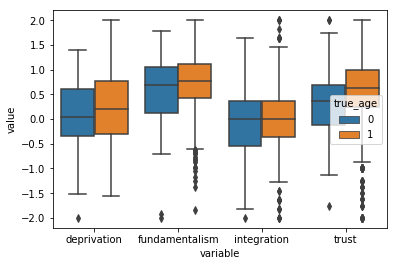

In [35]:
fig, axes = plt.subplots(1, 1)
sns.boxplot(x="variable", y="value", hue='true_age', data=df_melted, ax=axes)

# groupby and create combinations and fill missing values

In [36]:
def mix(x):
    return pd.Series({'integration':list(x.integration),\
                      'trust': list(x.trust),\
                      'deprivation': list(x.deprivation),\
                      'fundamentalism': list(x.fundamentalism)})


In [37]:
df_combinations = df_filled.groupby(['age', 'male?', 'immigrant?', 'muslim?']).apply(mix)
df_combinations.head()
# reorder indices according to NL

integration  \
age male? immigrant? muslim?                                                      
1.0 0     0.0        0.0      [1.272727272727273, 0.7272727272727271, -0.545...   
                     1.0                                 [-0.15151515151515157]   
          1.0        0.0             [0.36363636363636376, -0.5454545454545454]   
                     1.0                                  [-0.7272727272727273]   
    1     0.0        0.0      [-0.36363636363636354, 1.0909090909090908, 0.5...   

                                                                          trust  \
age male? immigrant? muslim?                                                      
1.0 0     0.0        0.0      [1.375, 1.125, 0.625, 2.0, 0.375, -0.25, 1.0, ...   
                     1.0                                   [0.7678571428571429]   
          1.0        0.0                                         [1.125, -0.75]   
                     1.0                                                 [-0.5]   
    1     0.0        0.0      [0.5, 0.625, 0.5, 0.75, 0.625, 0.875, 0.625, 1...   

                                                                    deprivation  \
age male? immigrant? muslim?                                                      
1.0 0     0.0        0.0      [0.7922248995983936, 0.6894136546184741, 0.876...   
                     1.0                                    [0.788540829986613]   
          1.0        0.0            [-1.3226024096385542, 0.056224899598393385]   
                     1.0                                 [-0.00816064257028093]   
    1     0.0        0.0      [0.9574939759036143, 0.9795983935742969, 1.042...   

                                                                 fundamentalism  
age male? immigrant? muslim?                                                     
1.0 0     0.0        0.0      [0.1900452488687785, 0.37104072398190047, 0.15...  
                     1.0                                   [1.0769230769230769]  
          1.0        0.0               [0.9683257918552037, 1.3846153846153846]  
                     1.0                                   [1.0407239819004523]  
    1     0.0        0.0      [0.15384615384615374, 0.751131221719457, 1.239...

In [38]:
mux = pd.MultiIndex.from_product(df_combinations.index.levels, names=['age','male?', 'immigrant?', 'muslim?'])

In [39]:
df_combinations = df_combinations.reindex(mux, fill_value=[0]).reset_index()

In [40]:
df_combinations_reordered = df_combinations[['immigrant?', 'male?', 'muslim?', 'age', 'integration', 'trust', 'deprivation', 'fundamentalism']]

In [41]:
df_combinations_reordered.to_csv("data/combination_data.csv", index=None)

In [42]:
print("Current combinations are {}, while theoretical combinations are {}".format(len(df_combinations), (len(pd.unique(df_combinations.age)) * 2 * 2 * 2)))

Current combinations are 48, while theoretical combinations are 48


In [43]:
population_data = resample(df_filled, replace=True, n_samples=100000)
population_data.to_csv("data/bootstrapped_data.csv", index=None)

In [44]:
df_combinations

,age,male?,immigrant?,muslim?,integration,trust,deprivation,fundamentalism
0,1.0,0,0.0,0.0,"[1.272727272727273, 0.7272727272727271, -0.545...","[1.375, 1.125, 0.625, 2.0, 0.375, -0.25, 1.0, ...","[0.7922248995983936, 0.6894136546184741, 0.876...","[0.1900452488687785, 0.37104072398190047, 0.15..."
1,1.0,0,0.0,1.0,[-0.15151515151515157],[0.7678571428571429],[0.788540829986613],[1.0769230769230769]
2,1.0,0,1.0,0.0,"[0.36363636363636376, -0.5454545454545454]","[1.125, -0.75]","[-1.3226024096385542, 0.056224899598393385]","[0.9683257918552037, 1.3846153846153846]"
3,1.0,0,1.0,1.0,[-0.7272727272727273],[-0.5],[-0.00816064257028093],[1.0407239819004523]
4,1.0,1,0.0,0.0,"[-0.36363636363636354, 1.0909090909090908, 0.5...","[0.5, 0.625, 0.5, 0.75, 0.625, 0.875, 0.625, 1...","[0.9574939759036143, 0.9795983935742969, 1.042...","[0.15384615384615374, 0.751131221719457, 1.239..."
5,1.0,1,0.0,1.0,"[0.0, 0.5454545454545454]","[0.125, -0.375]","[0.6308112449799199, -0.5606425702811244]","[0.570135746606335, 1.0950226244343892]"
6,1.0,1,1.0,0.0,[-0.36363636363636354],[-0.25],[-0.1171148594377509],[-1.9276018099547512]
7,1.0,1,1.0,1.0,[-0.1161616161616162],[0.5863095238095238],[0.7163444890673807],[0.6606334841628959]
8,2.0,0,0.0,0.0,"[0.18181818181818166, -0.5454545454545454, 0.9...","[0.375, 1.0, 1.25, 1.5, 0.625, 0.75, 1.625, 1....","[-0.7339823293172691, 1.1227630522088354, 0.05...","[0.4253393665158369, 0.7149321266968327, 0.389..."
9,2.0,0,0.0,1.0,"[0.36363636363636376, 0.7272727272727271]","[0.75, 0.75]","[0.8950361445783135, 1.3283855421686748]","[0.7149321266968327, 1.6923076923076925]"


### SOME STATS ON INDICES DISTRIBUTIONS

In [45]:
df_distrust["distrust_index_normalized"] = df_distrust.apply(lambda x: rescale(x["distrust_index"]), axis=1)

NameError: name 'df_distrust' is not defined

In [ ]:
df_distrust["distrust_index_normalized"].hist(bins=10)

In [ ]:
distrust = df_distrust[["RESPONDENT: AGE", "RESPONDENT: SEX", "RESPONDENT: RELIGIOUS DENOMINATION", "GERMAN CITIZENSHIP?", "distrust_index_normalized"]]
distrust.columns = ['age', 'sex', 'religion', 'resident', 'distrust']
distrust.head()

In [ ]:
pd.crosstab(distrust["religion"], [distrust["sex"], distrust["age"], distrust["resident"]], values=distrust["distrust"], aggfunc='mean').round(5)